<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Finite-Difference Playground: Using NRPy+-Generated C Codes in a Larger Project

## Author: Zach Etienne
### Formatting improvements courtesy Brandon Clark

## Introduction: 
To illustrate how NRPy+-based codes can be used, we write a C code that makes use of the NRPy+-generated C code from the [previous module](Tutorial-Finite_Difference_Derivatives.ipynb). This is a rather silly example, as the C code generated by NRPy+ could be easily generated by hand. However, as we will see in later modules, NRPy+'s true strengths lie in its automatic handling of far more complex and generic expressions, in higher dimensions. For the time being, bear with NRPy+; its true powers will become clear soon!

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

1. [Step 1](#outputc): Register the C function `finite_diff_tutorial__second_deriv()`
1. [Step 2](#fdplayground): Finite-Difference Playground: A Complete C Code for Analyzing Finite-Difference Expressions Output by NRPy+
1. [Step 3](#exercise): Exercises
1. [Step 4](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='outputc'></a>

# Step 1: Register the C function `finite_diff_tutorial__second_deriv()` \[Back to [top](#toc)\]
$$\label{outputc}$$

We start with the NRPy+ code from the [previous module](Tutorial-Finite_Difference_Derivatives.ipynb):

In [1]:
# Step P1: Import needed NRPy+ core modules:
import outputC as outC           # NRPy+: Core C code output module
import NRPy_param_funcs as par   # NRPy+: Parameter interface
import finite_difference as fin  # NRPy+: Finite difference C code generation module
import grid as gri               # NRPy+: Functions having to do with numerical grids
import indexedexp as ixp         # NRPy+: Symbolic indexed expression (e.g., tensors, vectors, etc.) support
import cmdline_helper as cmd     # NRPy+: Multi-platform Python command-line interface
import os, shutil                # Standard Python: multiplatform OS funcs

# Set the spatial dimension to 1
par.set_paramsvals_value("grid::DIM = 1")

# Register the input gridfunction "phi" and the gridfunction to which data are output, "output":
phi, output = gri.register_gridfunctions("AUX",["phi","output"])

# Declare phi_dDD as a rank-2 indexed expression: phi_dDD[i][j] = \partial_i \partial_j phi
phi_dDD = ixp.declarerank2("phi_dDD","nosym")

# Set output to \partial_0^2 phi
output = phi_dDD[0][0]

Now for the C code generation. First create the output directory for C codes.

In [2]:
# Step P2: Create C code output directory:
Ccodesrootdir = os.path.join("FiniteDifferencePlayground_Ccodes/")
# P2.a: First remove C code output directory if it exists
# Courtesy https://stackoverflow.com/questions/303200/how-do-i-remove-delete-a-folder-that-is-not-empty
shutil.rmtree(Ccodesrootdir, ignore_errors=True)
# P2.b: Then create a fresh directory
# Then create a fresh directory
cmd.mkdir(Ccodesrootdir)

Then declare C macros that will appear within `NRPy_basic_defines.h`, `#include`d in most C files within NRPy+ generated C codes.

In [3]:
outC.outC_NRPy_basic_defines_h_dict["FiniteDifferencePlayground"] = r"""
// Declare the IDX2S(gf,i) macro, which enables us to store 2-dimensions of
//   data in a 1D array. In this case, consecutive values of "i"
//   ("gf" held to a fixed value) are consecutive in memory, where
//   consecutive values of "gf" (fixing "i") are separated by N elements in
//   memory.
#define IDX2S(gf, i) ( (i) + Npts_in_stencil * (gf) )

// Declare PHIGF and OUTPUTGF, used for IDX2S's gf input.
#define PHIGF    0
#define OUTPUTGF 1
"""

Next, register the C function `finite_diff_tutorial__second_deriv()`, which contains the core C-code kernel for evaluating the finite-difference derivative.

Registering C functions with NRPy+ in this way encourages developers to abide by NRPy+ standards, in which 

* core functions are located within files of the same name
* code comments describing the function are well-formatted and appear at the top of the function
* function prototypes are automatically generated from information input into `add_to_Cfunction_dict()`
* generating of a fully functional `Makefile` from lists of C functions is automated and provided by `outputC`'s `construct_Makefile_from_outC_function_dict()`.

Further, it is conventional in NRPy+ to register C functions within a Python function, called at the bottom of a notebook/workflow. Turns out C-code generation of very complex expressions can take some time, and doing it via function calls enables us to parallelize the process (via Python's [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) module), resulting in much faster turnaround times.

Doing it this way also enables for functions to be automatically generated with multiple options, with each function specializing in a given option. For example, one could imagine outputting multiple such functions for different finite difference orders. When compared to C++ template metaprogramming ("[Difficulty level: Hard](https://www.geeksforgeeks.org/template-metaprogramming-in-c/)"), it is far simpler to gain familiarity with this more explicit approach.

In [4]:
def add_to_Cfunction_dict_finite_diff_tutorial__second_deriv():
    # includes field: list of files to #include at the top. NRPy_basic_defines.h defines C macros used here
    #                 for accessing gridfunction data.
    includes = ["stdio.h", "NRPy_basic_defines.h"]  # Add stdio.h in case we'd like to use printf() for debugging.
    prefunc  = ""  # would contain other functions that are *only* called by this function, declared static.
    desc = r"""Evaluate phi''(x0) the second derivative of phi, a function sampled on a uniform grid.

The derivative is evaluated using a standard 4th-order-accurate finite-difference approach.

See Tutorial-Finite_Difference_Derivatives.ipynb in https://github.com/zachetienne/nrpytutorial
for more details.
"""
    c_type = "void"
    name = "finite_diff_tutorial__second_deriv"
    params = "const double *in_gfs, const double invdx0, const int i0, const int Npts_in_stencil, double *aux_gfs"
    body = fin.FD_outputC("returnstring",
                          outC.lhrh(lhs=gri.gfaccess("aux_gfs", "output"), rhs=output),
                          params="preindent=1,includebraces=False") + "\n"
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body,
        enableCparameters=False)

Let's take a look at NRPy+'s generated version of this function. All we need to do is call the above function `add_to_Cfunction_dict_finite_diff_tutorial__second_deriv()` to register the function, and then it can be accessed directly from `outputC`'s `outC_function_master_list` list.

In [5]:
add_to_Cfunction_dict_finite_diff_tutorial__second_deriv()
for item in outC.outC_function_master_list:
    print(outC.outC_function_dict[item.name])

#include "stdio.h"
#include "./NRPy_basic_defines.h"
/*
 * Evaluate phi''(x0) the second derivative of phi, a function sampled on a uniform grid.
 * 
 * The derivative is evaluated using a standard 4th-order-accurate finite-difference approach.
 * 
 * See Tutorial-Finite_Difference_Derivatives.ipynb in https://github.com/zachetienne/nrpytutorial
 * for more details.
 */
void finite_diff_tutorial__second_deriv(const double *in_gfs, const double invdx0, const int i0, const int Npts_in_stencil, double *aux_gfs) {

  /*
   * NRPy+ Finite Difference Code Generation, Step 1 of 2: Read from main memory and compute finite difference stencils:
   */
  /*
   *  Original SymPy expression:
   *  "const double phi_dDD00 = invdx0**2*(-5*phi/2 + 4*phi_i0m1/3 - phi_i0m2/12 + 4*phi_i0p1/3 - phi_i0p2/12)"
   */
  const double phi_i0m2 = aux_gfs[IDX2S(PHIGF, i0-2)];
  const double phi_i0m1 = aux_gfs[IDX2S(PHIGF, i0-1)];
  const double phi = aux_gfs[IDX2S(PHIGF, i0)];
  const double phi_i0p1 = aux_gfs[IDX

<a id='fdplayground'></a>

# Step 2: Finite-Difference Playground: A Complete C Code for Analyzing Finite-Difference Expressions Output by NRPy+ \[Back to [top](#toc)\]
$$\label{fdplayground}$$

NRPy+ is designed to generate C code "kernels" at the heart of more advanced projects. As an example of its utility, let's now write a simple C code that imports the above file `finite_diff_tutorial-second_deriv.h` to evaluate the finite-difference second derivative of

$$f(x) = \sin(x)$$

at fourth-order accuracy. Let's call the finite-difference second derivative of $f$ evaluated at a point $x$ $f''(x)_{\rm FD}$. A fourth-order-accurate $f''(x)_{\rm FD}$ will, in the truncation-error-dominated regime, satisfy the equation

$$f''(x)_{\rm FD} = f''(x)_{\rm exact} + \mathcal{O}(\Delta x^4).$$

Therefore, the [relative error](https://en.wikipedia.org/wiki/Approximation_error) between the finite-difference derivative and the exact value should be given to good approximation by

$$E_{\rm Rel} = \left| \frac{f''(x)_{\rm FD} - f''(x)_{\rm exact}}{f''(x)_{\rm exact}}\right| \propto \Delta x^4,$$

so that (taking the logarithm of both sides of the equation):

$$\log_{10} E_{\rm Rel} = 4 \log_{10} (\Delta x) + \log_{10} (k),$$

where $k$ is the proportionality constant, divided by $f''(x)_{\rm exact}$.

Let's confirm this is true using our finite-difference playground code, which imports the NRPy+-generated C code generated above for evaluating $f''(x)_{\rm FD}$ at fourth-order accuracy, and outputs $\log_{10} (\Delta x)$ and $\log_{10} E_{\rm Rel}$ in a range of $\Delta x$ that is truncation-error dominated.

In [6]:
def add_to_Cfunction_dict_main__finite_difference_playground():
    includes = ["stdio.h", "stdlib.h", "math.h", "NRPy_basic_defines.h", "NRPy_function_prototypes.h"]
    prefunc  = r"""
// Define the function we wish to differentiate, as well as its exact second derivative:
double f(const double x)           { return  sin(x); } // f(x)
double f_dDD_exact(const double x) { return -sin(x); } // f''(x)

// Define the uniform grid coordinate:
//   x_i = (x_0 + i*Delta_x)
double x_i(const double x_0,const int i,const double Delta_x) {
  return (x_0 + (double)i*Delta_x);
}
"""
    desc = """// main() function:
// Step 0: Read command-line input, set up grid structure, allocate memory for gridfunctions, set up coordinates
// Step 1: Write test data to gridfunctions
// Step 2: Overwrite all data in ghost zones with NaNs
// Step 3: Apply curvilinear boundary conditions
// Step 4: Print gridfunction data after curvilinear boundary conditions have been applied
// Step 5: Free all allocated memory
"""
    c_type = "int"
    name = "main"
    params = "int argc, const char *argv[]"
    body  = r"""  // Step 0: Read command-line arguments (TODO)

  // Step 1: Set some needed constants
  const int Npts_in_stencil = 5; // Equal to the finite difference order, plus one.  '+str(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER"))+'+1;
  const double PI = 3.14159265358979323846264338327950288; // The scale over which the sine function varies.
  const double x_eval = PI/4.0; // x_0 = desired x at which we wish to compute f(x)

  // Step 2: Evaluate f''(x_eval) using the exact expression:
  double EX = f_dDD_exact(x_eval);

  // Step 3: Allocate space for gridfunction input and output.
  double *restrict gfs  = (double *restrict)malloc(sizeof(double)*Npts_in_stencil*2);

  // Step 4: Loop over grid spacings
  for(double Delta_x = 1e-3*(2*PI);Delta_x<=1.5e-1*(2*PI);Delta_x*=1.1) {

    // Step 4a: x_eval is the center point of the finite differencing stencil,
    //          thus x_0 = x_eval - 2*dx for fourth-order-accurate first & second finite difference derivs,
    //          and  x_0 = x_eval - 3*dx for sixth-order-accurate first & second finite difference derivs, etc.
    //          In general, for the integer Npts_in_stencil, we have
    //          x_0 = x_eval - (double)(Npts_in_stencil/2)*Delta_x,
    //          where we rely upon integer arithmetic (which always rounds down) to ensure
    //          Npts_in_stencil/2 = 5/2 = 2 for fourth-order-accurate first & second finite difference derivs:
    const double x_0 = x_eval - (double)(Npts_in_stencil/2)*Delta_x;

    // Step 4b: Set \phi=PHIGF to be f(x) as defined in the
    //          f(const double x) function above, where x_i = stencil_start_x + i*Delta_x:
    for(int ii=0;ii<Npts_in_stencil;ii++) {
      gfs[IDX2S(PHIGF, ii)] = f(x_i(x_0, ii, Delta_x));
    }

    // Step 4c: Set invdx0, which is needed by the NRPy+-generated "finite_diff_tutorial-second_deriv.h"
    const double invdx0 = 1.0/Delta_x;

    // Step 4d: Evaluate the finite-difference second derivative of f(x):
    const int i0 = Npts_in_stencil/2; // The derivative is evaluated at the center of the stencil.
    finite_diff_tutorial__second_deriv(gfs, invdx0, i0, Npts_in_stencil, gfs);
    double FD = gfs[IDX2S(OUTPUTGF, i0)];

    // Step 4e: Print log_10(\Delta x) and log_10([relative error])
    printf("%e\t%.15e\n",log10(Delta_x),log10(fabs((EX-FD)/(0.5*(EX+FD)))));
  }

  // Step 5: Free the allocated memory for the gridfunctions.
  free(gfs);

  return 0;
"""
    outC.add_to_Cfunction_dict(
        includes=includes,
        prefunc=prefunc,
        desc=desc,
        c_type=c_type, name=name, params=params,
        body=body, enableCparameters=False)

In [7]:
# Generate NRPy_basic_defines.h
outC.construct_NRPy_basic_defines_h(Ccodesrootdir)
# Generate function prototypes for functions registered with outC so far:
outC.construct_NRPy_function_prototypes_h(Ccodesrootdir)

# No need to add main() function prototype, so we add main() here:
add_to_Cfunction_dict_main__finite_difference_playground()

Next we compile and run the C code.

In [8]:
import cmdline_helper as cmd
# from outputC import construct_Makefile_from_outC_function_dict
# construct_Makefile_from_outC_function_dict(Ccodesrootdir, "CurviBC_Playground", compiler_opt_option="fast")
cmd.new_C_compile(Ccodesrootdir, "FiniteDifferencePlayground", compiler_opt_option="fast") # fastdebug or debug also supported
os.chdir(Ccodesrootdir)
cmd.Execute("FiniteDifferencePlayground",  # Executable name
            "",                            # Command-line arguments to executable
            "data.txt")                    # Redirect stdout to "data.txt"

(EXEC): Executing `make -j18`...
(BENCH): Finished executing in 0.20 seconds.
Finished compilation.
(EXEC): Executing `taskset -c 1,3,5,7,9,11,13,15 ./FiniteDifferencePlayground `...
(BENCH): Finished executing in 0.20 seconds.


Finally, let's plot $\log_{10} E_{\rm Rel}$ as a function of $\log_{10} (\Delta x)$. Again, the expression at fourth-order accuracy should obey

$$\log_{10} E_{\rm Rel} = 4 \log_{10} (\Delta x) + \log_{10} (k).$$

Defining $\hat{x} = \log_{10} (\Delta x)$ and $y(\hat{x})=\log_{10} E_{\rm Rel}$, we can write the above equation in the more suggestive form:

$$y(\hat{x}) = 4 \hat{x} + \log_{10} (k),$$

so $y(\hat{x}) = \log_{10} E_{\rm Rel}\left(\log_{10} (\Delta x)\right)$ should be a line with positive slope of 4.

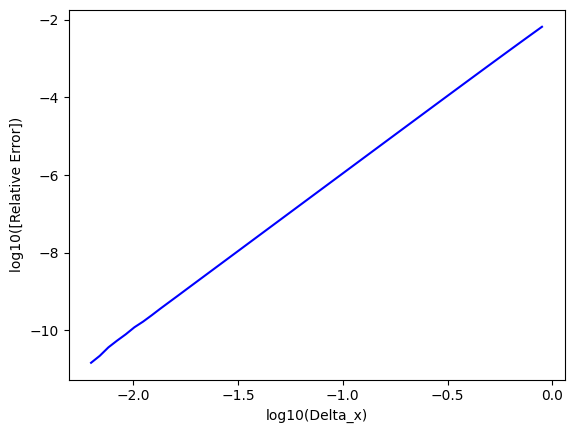

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

# from https://stackoverflow.com/questions/52386747/matplotlib-check-for-empty-plot
import numpy
x, y = numpy.loadtxt(fname='data.txt', delimiter='\t', unpack=True)
fig, ax = plt.subplots()
ax.set_xlabel('log10(Delta_x)')
ax.set_ylabel('log10([Relative Error])')
ax.plot(x, y, color='b')

os.chdir("..")

A quick glance at the above plot indicates that between $\log_{10}(\Delta x) \approx -2.0$ and $\log_{10}(\Delta x) \approx -1.0$, the logarithmic relative error $\log_{10} E_{\rm Rel}$ increases by about 4, indicating a positive slope of approximately 4. Thus we have confirmed fourth-order convergence.

<a id='exercise'></a>

# Step 3: Exercises \[Back to [top](#toc)\]
$$\label{exercise}$$

1. Use NumPy's [`polyfit()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html)  function to evaluate the least-squares slope of the above line.
2. Explore $\log_{10}(\Delta x)$ outside the above (truncation-error-dominated) range. What other errors dominate outside the truncation-error-dominated regime?
3. Adjust the above NRPy+ and C codes to support 6th-order-accurate finite differencing. What should the slope of the resulting plot of $\log_{10} E_{\rm Rel}$ versus $\log_{10}(\Delta x)$ be? Explain why this case does not provide as clean a slope as the 4th-order case.

<a id='latex_pdf_output'></a>

# Step 4: Output this notebook to $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{latex_pdf_output}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-Start_to_Finish-Finite_Difference_Playground.pdf](Tutorial-Start_to_Finish-Finite_Difference_Playground.pdf). (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [10]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-Start_to_Finish-Finite_Difference_Playground")

Created Tutorial-Start_to_Finish-Finite_Difference_Playground.tex, and
    compiled LaTeX file to PDF file Tutorial-Start_to_Finish-
    Finite_Difference_Playground.pdf
